In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
 
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE= 256
BATCH_SIZE=32
Epochs= 10
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data/plantimage",
    shuffle= True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names= dataset.class_names

Found 2152 files belonging to 3 classes.


In [4]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
%matplotlib inline
for image_batch,label_batch in dataset.take(0):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8, test_split=0.1,val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
    
    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    
    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(val_ds)

6

In [10]:
len(test_ds)

8

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu' ),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [17]:
history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data= val_ds
)

Epoch 1/10
54/54 [==============================] - 215s 4s/step - loss: 0.8008 - accuracy: 0.6015 - val_loss: 1.1530 - val_accuracy: 0.6354
Epoch 2/10
54/54 [==============================] - 192s 3s/step - loss: 0.4510 - accuracy: 0.8380 - val_loss: 0.5203 - val_accuracy: 0.7976
Epoch 3/10
54/54 [==============================] - 194s 4s/step - loss: 0.3525 - accuracy: 0.8628 - val_loss: 0.5074 - val_accuracy: 0.8073
Epoch 4/10
54/54 [==============================] - 189s 3s/step - loss: 0.3391 - accuracy: 0.8703 - val_loss: 0.3725 - val_accuracy: 0.8646
Epoch 5/10
54/54 [==============================] - 189s 3s/step - loss: 0.2018 - accuracy: 0.9290 - val_loss: 0.4536 - val_accuracy: 0.8281
Epoch 6/10
54/54 [==============================] - 196s 4s/step - loss: 0.1978 - accuracy: 0.9255 - val_loss: 0.4790 - val_accuracy: 0.8021
Epoch 7/10
54/54 [==============================] - 198s 4s/step - loss: 0.1705 - accuracy: 0.9360 - val_loss: 0.4464 - val_accuracy: 0.8333
Epoch 8/10
54

In [18]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 503ms/step - loss: 0.2811 - accuracy: 0.8789


In [19]:
scores

[0.2811148166656494, 0.87890625]

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

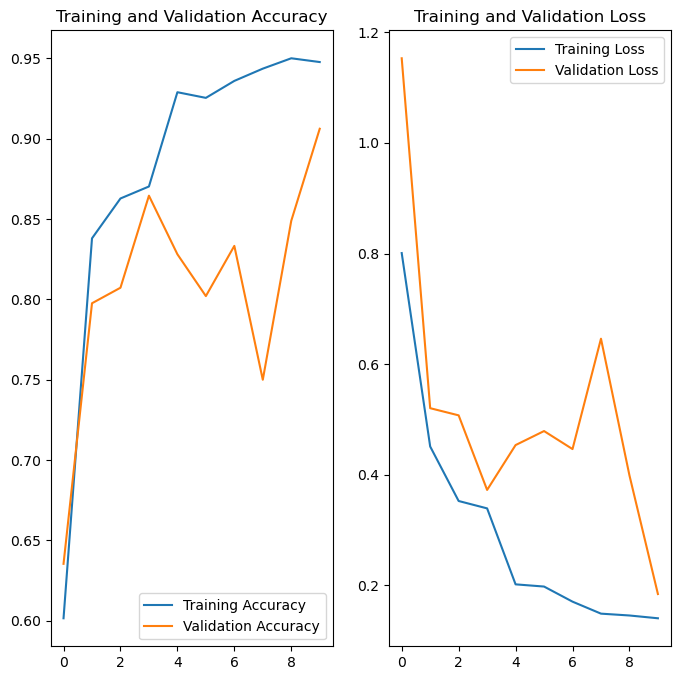

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 692ms/step
predicted label: Potato___Late_blight


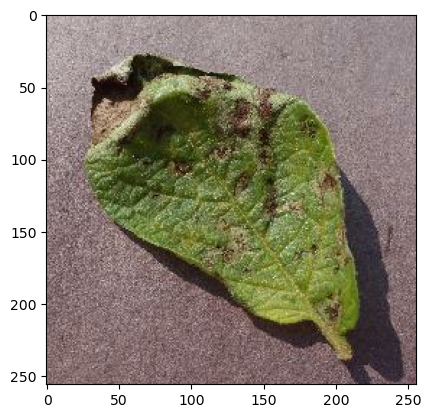

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 48ms/step


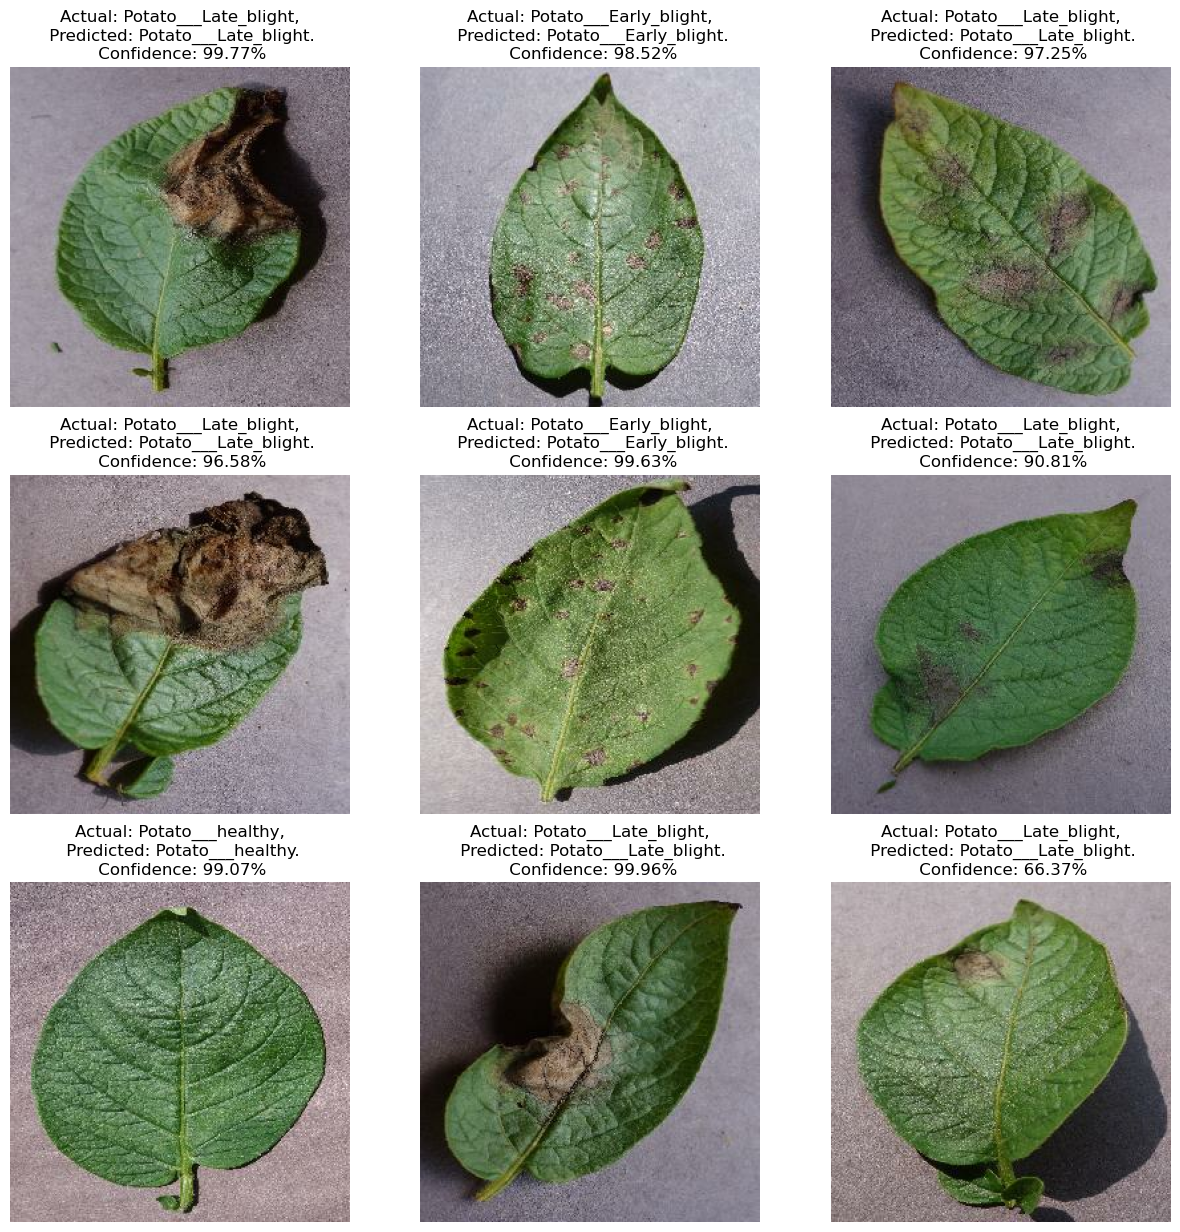

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [26]:
import os

model_dir = "../models"
existing_models = [int(name) for name in os.listdir(model_dir) if name.isdigit()]
model_version = max(existing_models, default=0) + 1
model.save(f"{model_dir}/{model_version}")



INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets
